In [86]:
import pandas as pd
import numpy as np
import gc
import sklearn
import xgboost as xgb
import catboost as ctb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, log_loss, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [87]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
src_train = pd.read_csv('data/train.csv')
groupID = test['Group']
train.head(5)

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,...,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Quality_label
0,0.001660,0.591013,147.608373,38.186345,0.000421,0.000612,2286.523413,0.035407,0.593081,1.010385,...,0.168761,1.098755,36.955992,8.454598,11.438066,177.243120,338.729256,2.021704,0.079526,Pass
1,1.601749,0.015052,0.035864,51.130326,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,...,11.649033,0.066671,225.632949,0.481860,20597.447822,3.723330,15.376190,0.986973,4.634376,Fail
2,0.098039,69.233685,0.080920,0.112265,0.000909,0.001972,2286.523413,0.035407,0.593081,1.010385,...,0.078213,110.079689,2.208138,0.073525,236.079314,0.064196,0.576302,33.875790,1.813727,Fail
3,18.181860,0.047325,0.018061,1.098102,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,...,0.380281,0.011491,0.654517,0.025872,176.948915,0.029777,0.246726,27.117165,0.081819,Fail
4,0.012085,0.008749,0.005509,524.327396,0.000909,0.002397,2286.523413,0.035407,0.593081,1.010385,...,1.555672,38.613386,0.260989,0.009380,194.798039,0.055053,0.014725,13.569707,18.138496,Fail


In [88]:
quality_map = {'Excellent': 0, 'Good': 1, 'Pass': 2, 'Fail': 3}
train['Quality_label'] = train['Quality_label'].map(quality_map)

full_data = pd.concat([train, test], ignore_index=True, sort=False)
full_data.tail()

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,...,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Quality_label,Group
11995,765.876721,0.053836,0.258969,0.125856,0.000218,0.000414,2286.523413,0.035407,0.593081,51.944717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0
11996,0.071211,0.924208,284.265495,15.668770,3.095123,1.817391,0.600827,17.850021,6.783967,0.195680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0
11997,0.001922,7.829744,16.138304,0.000376,0.741630,1.495371,0.600827,17.850021,0.051850,0.073078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0
11998,0.000054,0.672029,0.002134,0.149019,3.454681,3.262468,0.600827,17.850021,6.783967,0.027291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0
11999,1.026527,0.116152,2.923321,610.091923,1.031282,0.833011,0.038483,2.931083,2.005852,0.073078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.0


In [89]:
para_feat = ['Parameter{0}'.format(i) for i in range(5, 11)]
# para_feat = ['Parameter{0}'.format(i) for i in [5,6,7,10]]
para_feat_all = ['Parameter{0}'.format(i) for i in range(1, 11)]
attr_feat = ['Attribute{0}'.format(i) for i in range(1, 11)]

full_data[attr_feat] = np.log10(full_data[attr_feat])
full_data[para_feat_all] = np.log10(full_data[para_feat_all])
test_index = (full_data['Quality_label'].isnull()) | (full_data['Quality_label'] == -1)
train = full_data[~test_index]
test = full_data[test_index]

In [90]:
from sklearn.preprocessing import StandardScaler
features = ['Attribute4', 'Attribute5', 'Attribute6']
x = train.loc[:, features].values
x = StandardScaler().fit_transform(x)

In [91]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['p1', 'p2'])

In [92]:
principalDf['Quality_label'] = src_train['Quality_label']

In [93]:
principalDf

,p1,p2,Quality_label
0,1.406507,0.736586,Pass
1,1.380953,3.422652,Fail
2,-0.265881,1.964373,Fail
3,-0.800863,1.906743,Fail
4,-1.248371,1.982040,Fail
...,...,...,...
5995,-1.896014,0.796836,Pass
5996,-0.917524,0.902687,Pass
5997,-1.067193,0.949785,Pass
5998,-1.854479,0.621444,Pass


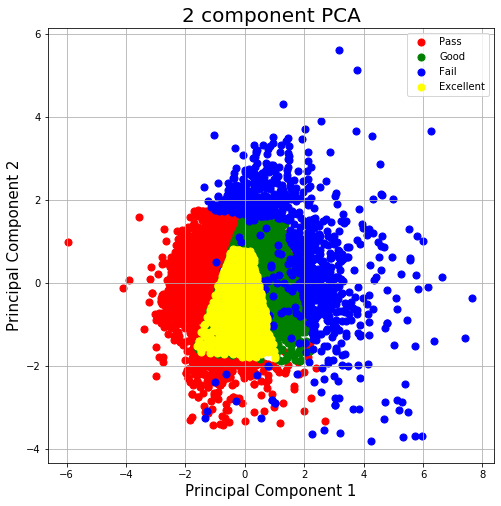

In [94]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Pass', 'Good', 'Fail', 'Excellent']
colors = ['r', 'g', 'b', 'yellow']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['Quality_label'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'p1']
               , principalDf.loc[indicesToKeep, 'p2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [95]:
train['p1'] = principalDf['p1']
train['p2'] = principalDf['p2']
train.head()

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,...,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Quality_label,Group,p1,p2
0,-2.779860,-0.228403,2.169111,1.581908,-3.375457,-3.213225,3.359176,-1.450909,-0.226886,0.004487,...,0.927093,1.058353,2.248569,2.529853,0.305718,-1.099493,2.0,NaN,1.406507,0.736586
1,0.204594,-1.822415,-1.445336,1.708679,-3.041347,-2.620330,3.359176,-1.450909,-0.226886,0.004487,...,-0.317079,4.313813,0.570932,1.186849,-0.005695,0.665991,3.0,NaN,1.380953,3.422652
2,-1.008602,1.840317,-1.091943,-0.949754,-3.041347,-2.705029,3.359176,-1.450909,-0.226886,0.004487,...,-1.133567,2.373058,-1.192495,-0.239350,1.529889,0.258572,3.0,NaN,-0.265881,1.964373
3,1.259638,-1.324909,-1.743252,0.040643,-3.041347,-2.620330,3.359176,-1.450909,-0.226886,0.004487,...,-1.587172,2.247848,-1.526116,-0.607785,1.433244,-1.087147,3.0,NaN,-0.800863,1.906743
4,-1.917741,-2.058059,-2.258966,2.719603,-3.041347,-2.620330,3.359176,-1.450909,-0.226886,0.004487,...,-2.027816,2.289585,-1.259219,-1.831939,1.132570,1.258601,3.0,NaN,-1.248371,1.982040


In [96]:
#************CTB 1*************

def my_scorer(y_true, y_predicted, X_test):
    loss_train = np.sum((y_true - y_predicted)**2, axis=0) / (X_test.shape[0])  #RMSE
    loss_train = loss_train **0.5
    score = 1/(1+loss_train)
    return score

def model(features, test_features, label, encoding='ohe', n_folds = 4):

    test_group = test_features['Group']
    
    labels = features[label]

    # Remove the ids and target
    features = features.drop(columns = [label])
    test_features = test_features.drop(columns = ['Group'])

    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    train_predictions = np.zeros(features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    #valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        model = ctb.CatBoostRegressor(iterations=1500, depth=6, learning_rate=0.01, loss_function='RMSE',
                                      logging_level='Verbose')

        # Train the model
        model.fit(train_features, train_labels,
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  early_stopping_rounds = 300, verbose = 5000)

        # Record the best iteration
#         best_iteration = model.best_iteration
#         print('BEST_ITER:', best_iteration)

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict(test_features)/ k_fold.n_splits
        train_predictions += model.predict(features)/ k_fold.n_splits
        # Record the out of fold predictions
        out_of_fold      = model.predict(valid_features)/ k_fold.n_splits

        # Record the best score
        train_score =  my_scorer(valid_labels,out_of_fold,valid_features)

        # valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'Group': test_group, label: test_predictions})
    train_sub = pd.DataFrame({label: train_predictions})
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    #valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    #valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metric = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            })

    return submission, feature_importances, metric, train_sub

In [97]:
# for i in range(4, 7):
for y in ['Attribute{0}'.format(i) for i in range(1, 11)] + ['p1', 'p2']:
#     feat = ['Parameter{0}'.format(i) for i in range(1, 11)] + ['p1', 'p2']
#     y = 'Attribute{0}'.format(i)
    X_train = train[para_feat + [y]]
    X_test = test[para_feat + ['Group']]

    submission, fi, metric, train_sub = model(X_train, X_test, y)
    train['ctb1_'+y] = train_sub[y]
    test['ctb1_'+y] = submission[y]
    print('\nPrediction of', y, 'is done!\n')
    
train.to_csv('final_data/ctb1_train.csv', index=False)
test.to_csv('final_data/ctb1_test.csv', index=False)

Training Data Shape:  (6000, 6)
Testing Data Shape:  (6000, 6)
0:	learn: 2.1939324	test: 2.2214718	test1: 2.1939324	best: 2.1939324 (0)	total: 4.86ms	remaining: 7.29s
1499:	learn: 2.1167584	test: 2.2436739	test1: 2.1167584	best: 2.1167584 (1499)	total: 3.59s	remaining: 0us

bestTest = 2.116758373
bestIteration = 1499

0:	learn: 2.2196542	test: 2.1424758	test1: 2.2196542	best: 2.2196542 (0)	total: 17ms	remaining: 25.5s
1499:	learn: 2.1464007	test: 2.1470554	test1: 2.1464007	best: 2.1464007 (1499)	total: 4.07s	remaining: 0us

bestTest = 2.146400706
bestIteration = 1499

0:	learn: 2.1937905	test: 2.2212563	test1: 2.1937905	best: 2.1937905 (0)	total: 5.57ms	remaining: 8.35s
1499:	learn: 2.1099508	test: 2.2475128	test1: 2.1099508	best: 2.1099508 (1499)	total: 5.78s	remaining: 0us

bestTest = 2.109950815
bestIteration = 1499

0:	learn: 2.1946849	test: 2.2191681	test1: 2.1946849	best: 2.1946849 (0)	total: 8.49ms	remaining: 12.7s
1499:	learn: 2.1153550	test: 2.2411419	test1: 2.1153550	best: 2.

In [22]:
#************XGB 1*************

def my_scorer(y_true, y_predicted, X_test):
    loss_train = np.sum((y_true - y_predicted)**2, axis=0) / (X_test.shape[0])  #RMSE
    loss_train = loss_train **0.5
    score = 1/(1+loss_train)
    return score

def model(features, test_features, label, encoding='ohe', n_folds = 4):

    test_group = test_features['Group']
    
    labels = features[label]

    # Remove the ids and target
    features = features.drop(columns = [label])
    test_features = test_features.drop(columns = ['Group'])

    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    train_predictions = np.zeros(features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    #valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = xgb.XGBRegressor(objective = 'reg:linear',n_estimators=2000, min_child_weight=1, num_leaves=20,
                                   learning_rate = 0.01, max_depth=6, n_jobs=20,
                                   subsample = 0.6, colsample_bytree = 0.4, colsample_bylevel = 1)

        # Train the model
        model.fit(train_features, train_labels,
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  early_stopping_rounds = 300, verbose = 5000)

        # Record the best iteration
        best_iteration = model.best_iteration
        print('BEST_ITER:', best_iteration)

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict(test_features)/ k_fold.n_splits
        train_predictions += model.predict(features)/ k_fold.n_splits
        # Record the out of fold predictions
        out_of_fold      = model.predict(valid_features)/ k_fold.n_splits

        # Record the best score
        train_score =  my_scorer(valid_labels,out_of_fold,valid_features)

        # valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'Group': test_group, label: test_predictions})
    train_sub = pd.DataFrame({label: train_predictions})
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    #valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    #valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metric = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            })

    return submission, feature_importances, metric, train_sub

In [23]:
train = pd.read_csv('final_data/ctb1_train.csv')
test = pd.read_csv('final_data/ctb1_test.csv')
# for i in range(4, 7):
for y in ['Attribute{0}'.format(i) for i in range(1, 11)] + ['p1', 'p2']:
#     feat = ['Parameter{0}'.format(i) for i in range(1, 11)] + ['p1', 'p2']
#     y = 'Attribute{0}'.format(i)
    X_train = train[para_feat + [y]]
    X_test = test[para_feat + ['Group']]

    submission, fi, metric, train_sub = model(X_train, X_test, y)
    train['xgb1_'+y] = train_sub[y]
    test['xgb1_'+y] = submission[y]
    print('\nPrediction of', y, 'is done!\n')
    
train.to_csv('final_data/xgb1_train.csv', index=False)
test.to_csv('final_data/xgb1_test.csv', index=False)

Training Data Shape:  (6000, 6)
Testing Data Shape:  (6000, 6)
[15:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.25744	validation_1-rmse:2.26044
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 300 rounds.
[1999]	validation_0-rmse:2.32625	validation_1-rmse:1.99836
BEST_ITER: 1999
[15:26:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.20392	validation_1-rmse:2.27802
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 300 rounds.
[1999]	validation_0-rmse:2.18496	validation_1-rmse:2.04197
BEST_ITER: 1999
[15:26:29] WARNING: C:/Jenk

In [24]:
# pred_attr_feat = ['xgb_Attribute{0}'.format(i) for i in range(4, 7)]
# test[attr_feat + pred_attr_feat].head(20)
test.head()

,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,...,xgb1_Attribute3,xgb1_Attribute4,xgb1_Attribute5,xgb1_Attribute6,xgb1_Attribute7,xgb1_Attribute8,xgb1_Attribute9,xgb1_Attribute10,xgb1_p1,xgb1_p2
0,-0.628417,-0.454090,-0.728591,-1.063207,0.156567,0.090050,-1.414726,0.467028,0.302299,-0.708453,...,0.422993,0.009790,0.666180,-0.891161,-0.132688,-0.406348,-0.477419,-0.018344,0.239275,-0.770448
1,-1.358538,1.513094,-0.052427,1.472793,-1.561715,-1.773336,-0.221251,-0.927835,2.948223,-0.280689,...,-1.031966,2.025417,0.369417,2.378591,1.176796,1.238690,1.630638,1.528413,1.550742,1.823246
2,1.331766,1.073637,4.900365,4.131766,-1.561715,-1.773336,-0.221251,-0.927835,2.948223,-0.280689,...,-1.031966,2.025417,0.369417,2.378591,1.176796,1.238690,1.630638,1.528413,1.550742,1.823246
3,-0.152554,-1.742806,2.501081,1.580783,-0.368463,-0.502846,-1.414726,1.251639,-1.285255,-1.991743,...,-0.029555,1.052139,1.622052,-0.817889,1.224953,0.825307,0.162978,-0.148923,1.367410,-0.788233
4,1.019031,1.203683,-0.001719,1.223124,-0.320733,-0.333447,-1.414726,1.251639,-1.285255,-1.991743,...,-0.192983,0.965949,1.275539,-0.540761,0.373637,0.410098,0.423164,0.314448,1.169121,-0.546591


In [25]:
#***************LGB 1****************

def model(features, test_features, label, encoding='ohe', n_folds = 4):

    test_group = test_features['Group']
    
    labels = features[label]

    # Remove the ids and target
    features = features.drop(columns = [label])
    test_features = test_features.drop(columns = ['Group'])

    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    train_predictions = np.zeros(features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = lgb.LGBMRegressor(objective = 'regression',n_estimators=2000,min_child_samples=20,num_leaves=20,
                                   learning_rate = 0.005, feature_fraction=0.8,
                                   subsample = 0.5, n_jobs = -1, random_state = 50)

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'rmse',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 2000, verbose = 4000)

        # Record the best iteration
        best_iteration = model.best_iteration_
        print('BEST_ITER:', best_iteration)

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict(test_features, num_iteration = best_iteration)/ k_fold.n_splits
        train_predictions += model.predict(features, num_iteration = best_iteration)/ k_fold.n_splits
        # Record the out of fold predictions
        out_of_fold      = model.predict(valid_features, num_iteration = best_iteration)/ k_fold.n_splits

        # Record the best score
        valid_score = model.best_score_['valid']['rmse']
        train_score = model.best_score_['train']['rmse']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'Group': test_group, label: test_predictions})
    train_sub = pd.DataFrame({label: train_predictions})
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    #valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    #valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    valid_scores.append(np.mean(valid_scores))
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metric = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid':valid_scores})

    return submission, feature_importances, metric, train_sub

In [26]:
train = pd.read_csv('final_data/xgb1_train.csv')
test = pd.read_csv('final_data/xgb1_test.csv')

# for i in range(4, 7):
for y in ['Attribute{0}'.format(i) for i in range(1, 11)] + ['p1', 'p2']:
    new_feat = ['xgb1_'+y]
    X_train = train[para_feat + new_feat + [y]]
    X_test = test[para_feat + new_feat + ['Group']]

    submission, fi, metric, train_sub = model(X_train, X_test, y)
    train['lgb1_'+y] = train_sub[y]
    test['lgb1_'+y] = submission[y]
    print('\nPrediction of', y, 'is done!\n')
    
train.to_csv('final_data/lgb1_train.csv', index=False)
test.to_csv('final_data/lgb1_test.csv', index=False)

Training Data Shape:  (6000, 7)
Testing Data Shape:  (6000, 7)
Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[2000]	train's rmse: 1.87113	train's l2: 3.50112	valid's rmse: 2.15252	valid's l2: 4.63333
BEST_ITER: 2000
Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[2000]	train's rmse: 1.91049	train's l2: 3.64999	valid's rmse: 2.02551	valid's l2: 4.1027
BEST_ITER: 2000
Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[2000]	train's rmse: 1.88525	train's l2: 3.55416	valid's rmse: 2.1349	valid's l2: 4.55781
BEST_ITER: 2000
Training until validation scores don't improve for 2000 rounds
Did not meet early stopping. Best iteration is:
[2000]	train's rmse: 1.8687	train's l2: 3.49205	valid's rmse: 2.15578	valid's l2: 4.64739
BEST_ITER: 2000

Prediction of Attribute1 is done!

Training Data Shape:  (6000, 7)


In [27]:
# pred_attr_feat = ['lgb_Attribute{0}'.format(i) for i in range(4, 7)]
# test[attr_feat + pred_attr_feat].head(20)

In [28]:
#******************LGB 2*****************

def model(features, test_features, label, encoding='ohe', n_folds = 4):

    test_group = test_features['Group']
    
    labels = features[label]

    # Remove the ids and target
    features = features.drop(columns = [label])
    test_features = test_features.drop(columns = ['Group'])

    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    train_predictions = np.zeros(features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = lgb.LGBMRegressor(objective = 'regression',n_estimators=5000,min_child_samples=20,num_leaves=26,
                                   learning_rate = 0.005, feature_fraction=0.6,
                                   subsample = 0.4, n_jobs = -1, random_state = 50)

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'rmse',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 2000, verbose = 4000)

        # Record the best iteration
        best_iteration = model.best_iteration_
        print('BEST_ITER:', best_iteration)

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict(test_features, num_iteration = best_iteration)/ k_fold.n_splits
        train_predictions += model.predict(features, num_iteration = best_iteration)/ k_fold.n_splits
        # Record the out of fold predictions
        out_of_fold      = model.predict(valid_features, num_iteration = best_iteration)/ k_fold.n_splits

        # Record the best score
        valid_score = model.best_score_['valid']['rmse']
        train_score = model.best_score_['train']['rmse']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'Group': test_group, label: test_predictions})
    train_sub = pd.DataFrame({label: train_predictions})
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    #valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    #valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    valid_scores.append(np.mean(valid_scores))
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metric = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid':valid_scores})

    return submission, feature_importances, metric, train_sub

In [29]:
train = pd.read_csv('final_data/lgb1_train.csv')
test = pd.read_csv('final_data/lgb1_test.csv')

# for i in range(4, 7):
for y in ['Attribute{0}'.format(i) for i in range(1, 11)] + ['p1', 'p2']:
    new_feat = ['lgb1_'+y]
    X_train = train[para_feat + new_feat + [y]]
    X_test = test[para_feat + new_feat + ['Group']]

    submission, fi, metric, train_sub = model(X_train, X_test, y)
    train['lgb2_'+y] = train_sub[y]
    test['lgb2_'+y] = submission[y]
    print('\nPrediction of', y, 'is done!\n')
    
train.to_csv('final_data/lgb2_train.csv', index=False)
test.to_csv('final_data/lgb2_test.csv', index=False)

Training Data Shape:  (6000, 7)
Testing Data Shape:  (6000, 7)
Training until validation scores don't improve for 2000 rounds
Early stopping, best iteration is:
[520]	train's rmse: 1.87662	train's l2: 3.5217	valid's rmse: 2.02625	valid's l2: 4.10571
BEST_ITER: 520
Training until validation scores don't improve for 2000 rounds
Early stopping, best iteration is:
[552]	train's rmse: 1.91004	train's l2: 3.64824	valid's rmse: 1.90542	valid's l2: 3.63063
BEST_ITER: 552
Training until validation scores don't improve for 2000 rounds
Early stopping, best iteration is:
[616]	train's rmse: 1.87795	train's l2: 3.52668	valid's rmse: 1.99605	valid's l2: 3.98422
BEST_ITER: 616
Training until validation scores don't improve for 2000 rounds
Early stopping, best iteration is:
[524]	train's rmse: 1.87596	train's l2: 3.51924	valid's rmse: 2.01476	valid's l2: 4.05925
BEST_ITER: 524

Prediction of Attribute1 is done!

Training Data Shape:  (6000, 7)
Testing Data Shape:  (6000, 7)
Training until validation s